## Load the dataset

In [2]:
# !pip install pyarrow
# !pip install nltk
# !pip install wordcloud
# !pip install xgboost
# !pip install scikit-learn
# !pip install keras

import os
import gc
import re

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import wordcloud

from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
## Convert CSV files to Parquet format for faster data reading and processing
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()                            #garbage collect
    print(save_name, 'Done.')

In [5]:
def parquet_to_csv(parquet_path, save_name):
    # Parquet 파일을 불러옵니다.
    df = pd.read_parquet(parquet_path)

    # DataFrame을 CSV 파일로 저장합니다.
    df.to_csv(f'c:/data/project/{save_name}.csv', index=False)  # 'index=False'는 인덱스를 저장하지 않도록 설정합니다.
    print(save_name, 'Done.')

In [6]:
csv_to_parquet('c:/data/project/train.csv', 'train')
csv_to_parquet('c:/data/project/test.csv', 'test')

train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

train Done.
test Done.


In [7]:
# train 복사
train1 = train.copy()
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


In [8]:
train1.drop(columns=['ID'], inplace=True)

In [9]:
# train1.to_csv('c:/data/project/train_nlp.csv', index=False)

In [10]:
print(train1['first_party_winner'].value_counts())
train1.head(5)

first_party_winner
1    1649
0     829
Name: count, dtype: int64


,first_party,second_party,facts,first_party_winner
0,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana. During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union. Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. \nThompson successfully sued St. Amant for defamation. Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.” Thompson then appealed to the Supreme Court of Louisiana. That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true. Finally, that court held that the First Amendment protects uninhibited, robust debate, rather than an open season to shoot down the good name of anyone who happens to be a public servant. \n",1
1,Stephen Duncan,Lawrence Owens,"Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lineup, he was tried and convicted for Nelson’s death. Because Nelson was carrying cocaine and crack cocaine potentially for distribution, the judge at Owens’ bench trial ruled that Owens was probably also a drug dealer and was trying to “knock [Nelson] off.” Owens was found guilty of first-degree murder and sentenced to 25 years in prison.\nOwens filed a petition for a writ of habeas corpus on the grounds that his constitutional right to due process was violated during the trial. He argued that the eyewitness identification should have been inadmissible based on unreliability and that the judge impermissibly inferred a motive when a motive was not an element of the offense. The district court denied the writ of habeas corpus, and Owens appealed. The U.S. Court of Appeals for the Seventh Circuit reversed the denial and held that the trial judge’s inference about Owens’s motive violated his right to have his guilt adjudicated solely based on the evidence presented at trial.\n",0
2,Billy Joe Magwood,"Tony Patterson, Warden, et al.","An Alabama state court convicted Billy Joe Magwood of murder and sentenced him to death. Subsequently, an Alabama federal district court partially granted Mr. Magwood's petition for federal habeas corpus relief. The court upheld his conviction but instructed the state court to look at mitigating evidence when resentencing Mr. Magwood. Upon resentencing, the state court sentenced Mr. Magwood to death once again. Mr. Magwood filed a second petition for federal habeas corpus relief with the federal district court arguing that a judicial rule was retroactively applied in his case and that he lacked effective counsel at sentencing. The district court granted the petition and vacated Mr. Magwood's death sentence.\nOn appeal, the U.S. Court of Appeals for the Eleventh circuit reversed, holding that prisoners may not raise challenges to an original sentence that could have been raised in an earlier petition. The court also held that Mr. Magwood's counsel was not ineffective because he failed to raise an argument that had already been decided by the state's highest court adverse to his client's position.\n",1
3,Linkletter,Walker,"Victor Linkletter was convicted in state court on evidence illegally obtained by police prior to the Supreme Court decision concerning the Fourth Amendment in Mapp v. Ohio. Mapp applied the exclusionary rule to state criminal proceedings, denying the use of illegally obtained evidence at trial. Linkletter argued for a retrial based on the Mapp decision.\n",0
4,William Earl Fikes,Alabama,"On April 24, 1

In [11]:
# There isn't any missing values in this dataset
train1.isna().sum()

first_party           0
second_party          0
facts                 0
first_party_winner    0
dtype: int64

In [12]:
# Seqence Model Check (Not Pass)
text_vectorization = keras.layers.TextVectorization(
    max_tokens=1000, # adding more tokens to allow for increase due to bigrams.
    output_mode="multi_hot", # This is requesting integer encodings (which means we'll have a sequence of integers)
)
text_vectorization.adapt(train1['facts'])
vectorized_facts = text_vectorization(train1['facts'])


lengths = [len(x) for x in vectorized_facts]

print(f'The average fact in our data has {np.mean(lengths):.0f} words, and we have {len(train1)} samples.\n')

print(f'The ratio of samples to average sample length is {(len(train1)/np.mean(lengths)):.0f}. We are nowhere close to 1500.\n')

print(f'We need a larger dataset containing at least {(np.mean(lengths)*1500):.0f} samples.')


The average fact in our data has 1000 words, and we have 2478 samples.

The ratio of samples to average sample length is 2. We are nowhere close to 1500.

We need a larger dataset containing at least 1500000 samples.


## Data preprocessing

In [13]:
name_pet = []
name_rep = []
for i in range(train1.shape[0]):
  fact = train1["facts"][i]
  petitioner = train1["first_party"][i]
  respondent = train1["second_party"][i]
  p = True
  r = True
  for _ in petitioner.split():
    if _ in fact:
      p = True
      break
    else:
      p = False
  if p == False: 
    #name_pet.append("Petitioner name not found in {}".format(i))
    name_pet.append(i)
  for _ in respondent.split():
    if _ in fact:
      r = True
      break
    else:
      r = False
  if r == False:
    #name_rep.append("Respondent name not found in {}".format(i))
    name_rep.append(i)

In [14]:
perc_miss_pet = len(name_pet) / len(train1) * 100
print('{:.2f}% of facts don\'t contain the first party name'.format(perc_miss_pet))

perc_miss_rep = len(name_rep) / len(train1) * 100
print('{:.2f}% of facts don\'t contain the second party name'.format(perc_miss_rep))

perc_miss_both = len(set(set(name_pet) & set(name_rep))) / len(train1) * 100
print('{:.2f}% of facts don\'t contain both first party the second party names'.format(perc_miss_both))

16.34% of facts don't contain the first party name
18.97% of facts don't contain the second party name
3.31% of facts don't contain both first party the second party names


In [15]:
# Combining first party and second party with facts
train1['facts'] = train1['first_party']+' '+train1['second_party']+' '+train1['facts']

In [16]:
train1.head(3)

,first_party,second_party,facts,first_party_winner
0,Phil A. St. Amant,Herman A. Thompson,"Phil A. St. Amant Herman A. Thompson On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana. During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union. Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. \nThompson successfully sued St. Amant for defamation. Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.” Thompson then appealed to the Supreme Court of Louisiana. That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true. Finally, that court held that the First Amendment protects uninhibited, robust debate, rather than an open season to shoot down the good name of anyone who happens to be a public servant. \n",1
1,Stephen Duncan,Lawrence Owens,"Stephen Duncan Lawrence Owens Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lineup, he was tried and convicted for Nelson’s death. Because Nelson was carrying cocaine and crack cocaine potentially for distribution, the judge at Owens’ bench trial ruled that Owens was probably also a drug dealer and was trying to “knock [Nelson] off.” Owens was found guilty of first-degree murder and sentenced to 25 years in prison.\nOwens filed a petition for a writ of habeas corpus on the grounds that his constitutional right to due process was violated during the trial. He argued that the eyewitness identification should have been inadmissible based on unreliability and that the judge impermissibly inferred a motive when a motive was not an element of the offense. The district court denied the writ of habeas corpus, and Owens appealed. The U.S. Court of Appeals for the Seventh Circuit reversed the denial and held that the trial judge’s inference about Owens’s motive violated his right to have his guilt adjudicated solely based on the evidence presented at trial.\n",0
2,Billy Joe Magwood,"Tony Patterson, Warden, et al.","Billy Joe Magwood Tony Patterson, Warden, et al. An Alabama state court convicted Billy Joe Magwood of murder and sentenced him to death. Subsequently, an Alabama federal district court partially granted Mr. Magwood's petition for federal habeas corpus relief. The court upheld his conviction but instructed the state court to look at mitigating evidence when resentencing Mr. Magwood. Upon resentencing, the state court sentenced Mr. Magwood to death once again. Mr. Magwood filed a second petition for federal habeas corpus relief with the federal district court arguing that a judicial rule was retroactively applied in his case and that he lacked effective counsel at sentencing. The district court granted the petition and vacated Mr. Magwood's death sentence.\nOn appeal, the U.S. Court of Appeals for the Eleventh circuit reversed, holding that prisoners may not raise challenges to an original sentence that could have been raised in an earlier petition. The court also held that Mr. Magwood's counsel was not ineffective because he failed to raise an argument that had already been decided by the state's highest court adverse to his client's position.\n",1


## Imablance in Label class

first_party_winner
1    1649
0     829
Name: count, dtype: int64


<Axes: ylabel='Type'>

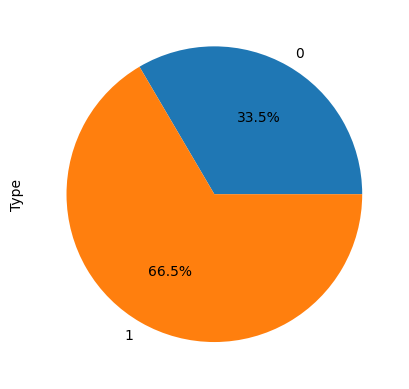

In [17]:
print(train1["first_party_winner"].value_counts())

train1.groupby('first_party_winner').size().plot(kind='pie',
                                    y = "first_party_winner",
                                    label = "Type",
                                    autopct='%1.1f%%')

## Train-Test Split

In [18]:
# Perform an 80-20 split for training and testing data
X_train, X_test, \
y_train, y_test = train_test_split(
    train1[['first_party_winner', 'facts']],
    train1['first_party_winner'],
    test_size=0.2,
    stratify=train1['first_party_winner'],
    random_state=865
)

In [19]:
petitioner = X_train[X_train["first_party_winner"] == 0]
respondent = X_train[X_train["first_party_winner"] == 1]
print(petitioner.shape)
print(respondent.shape)

(663, 2)
(1319, 2)


## Upsampling train data

In [20]:
from sklearn.utils import resample
upsample_respondent = resample(respondent,
            replace=True,
            n_samples=len(petitioner),
            random_state=865)

first_party_winner
1    663
0    663
Name: count, dtype: int64


<Axes: ylabel='Type'>

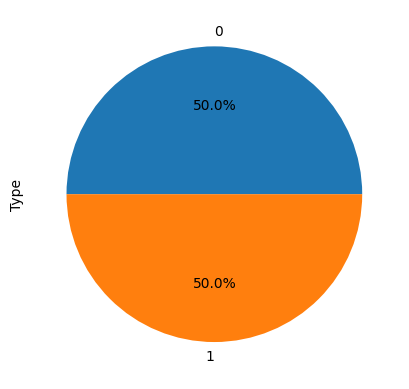

In [21]:
upsample_train = pd.concat([upsample_respondent, petitioner])

print(upsample_train["first_party_winner"].value_counts())

upsample_train.groupby('first_party_winner').size().plot(kind='pie',
                                    y = "first_party_winner",
                                    label = "Type",
                                    autopct='%1.1f%%')

In [22]:
# Let's shuffle things... 
shuffled_indices= np.arange(upsample_train.shape[0])
np.random.shuffle(shuffled_indices)

In [23]:
shuffled_train = upsample_train.iloc[shuffled_indices,:]

X_train= shuffled_train['facts']

y_train = shuffled_train['first_party_winner']

In [24]:
# Dropping winner_index in X_test set
X_test = X_test['facts']

## Simple neural network

In [25]:
# define tokenizer function

def nltk_tokenizer(_wd):
    return RegexpTokenizer(r'\w+').tokenize(_wd.lower())

In [26]:
# turn X data into pandas dataframe to use custom defined function on a column in dataframe
X_train_frame = X_train.to_frame()
X_test_frame = X_test.to_frame()

# tokenize facts
X_train_frame["tokenized_facts"] = X_train_frame["facts"].apply(nltk_tokenizer)
X_test_frame["tokenized_facts"] = X_test_frame["facts"].apply(nltk_tokenizer)

# make taggeddocument, which is required format to use Doc2vec
tokens_train = X_train_frame["tokenized_facts"].to_list()
docs_train = [TaggedDocument(t, [str(i)]) for i, t in enumerate(tokens_train)]
tokens_test = X_test_frame["tokenized_facts"].to_list()
docs_test = [TaggedDocument(t, [str(i)]) for i, t in enumerate(tokens_test)]

In [27]:
# innitiate doc2vec model and train it on train data
doc2vec_model = Doc2Vec(vector_size=50, min_count=2, epochs=40, dm=1, seed=865, window=5)
doc2vec_model.build_vocab(docs_train)
doc2vec_model.train(docs_train, total_examples = doc2vec_model.corpus_count, epochs = doc2vec_model.epochs)

In [28]:
# vectorize train and test data using doc2vec model
X_train_dvs = [doc2vec_model.infer_vector(doc) for doc in tokens_train]
X_train_dvs = pd.DataFrame(X_train_dvs, index = X_train.index)

X_test_dvs = [doc2vec_model.infer_vector(doc) for doc in tokens_test]
X_test_dvs = pd.DataFrame(X_test_dvs, index = X_test.index)

Sequential은 Keras에서 모델을 만드는 방법 중 하나로, 레이어를 순서대로 쌓아 구성합니다.

Dropout 레이어는 학습 과정에서 무작위로 입력 유닛의 일부를 0으로 설정하여 과적합을 방지하는 방법입니다. 이 코드에서는  각 Dropout 레이어에서 30% 또는 40%의 유닛을 무작위로 비활성화합니다.

BatchNormalization 레이어는 각 배치에서 이전 레이어의 활성화 출력을 정규화하여 학습을 안정화하고 성능을 향상시킵니다.

Dense 레이어는 완전히 연결된 레이어로, 각 레이어의 모든 뉴런이 이전 레이어의 모든 뉴런과 연결되어 있습니다. 이 코드에서는 각 Dense 레이어가 200, 100, 50, 20, 그리고 1개의 뉴런을 갖습니다.

relu와 sigmoid는 활성화 함수로, 뉴런의 출력을 결정합니다. relu는 음수를 0으로 만들고, sigmoid는 출력을 0과 1 사이로 제한합니다.

kernel_regularizer는 가중치에 규제를 적용하는 방법으로, 이 코드에서는 L1 규제를 사용합니다. 규제는 모델이 과적합되는 것을 방지하기 위해 사용됩니다.

마지막으로, compile 메소드를 사용하여 모델의 학습 과정을 설정합니다. 이 코드에서는 adam 최적화 알고리즘을 사용하고, 손실 함수로 binary_crossentropy를 사용합니다. 이는 이진 분류 문제에 적합한 설정입니다. 또한, 학습 도중에 정확도를 모니터링하기 위해 accuracy를 메트릭으로 설정합니다.

In [29]:
# define Dense layer model
def simple_model():
    model =  keras.Sequential([
        layers.Dropout(0.3),
        layers.BatchNormalization(),      
        layers.Dense(200, activation="relu", kernel_regularizer="l1"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(100, activation="relu", kernel_regularizer="l1"),
        layers.Dropout(0.4),
        layers.BatchNormalization(),
        layers.Dense(50, activation="relu"),
        layers.Dropout(0.4),
        layers.BatchNormalization(),
        layers.Dense(20, activation="relu"),
        layers.Dropout(0.4),
        layers.BatchNormalization(),      
        layers.Dense(1, activation="sigmoid"),     
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [30]:
# train and cross validate the model

k = 4
num_validation_samples = len(X_train_dvs) // k
num_epochs = 30
batch_sizes = 50
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = X_train_dvs[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = y_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        X_train_dvs[:num_validation_samples * fold],
        X_train_dvs[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        y_train[:num_validation_samples * fold],
        y_train[num_validation_samples * (fold + 1):]])
    
    model1 = simple_model()

    history1 = model1.fit(training_data, training_targets, 
                    validation_data = (validation_data,validation_targets), 
                    epochs=num_epochs, batch_size=batch_sizes)

    val_loss_history1 = history1.history['val_loss']
    val_acc_history1 = history1.history['val_accuracy']
    loss_history1 = history1.history['loss']
    acc_history1 = history1.history['accuracy']
    all_val_loss_histories.append(val_loss_history1)
    all_loss_histories.append(loss_history1)
    all_val_acc_histories.append(val_acc_history1)
    all_acc_histories.append(acc_history1)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/30


20/20 [==============================] - 2s 13ms/step - loss: 21.4241 - accuracy: 0.4884 - val_loss: 19.7241 - val_accuracy: 0.4894
Epoch 2/30
20/20 [==============================] - 0s 4ms/step - loss: 18.6157 - accuracy: 0.5276 - val_loss: 17.1109 - val_accuracy: 0.5317
Epoch 3/30
20/20 [==============================] - 0s 3ms/step - loss: 16.1232 - accuracy: 0.5146 - val_loss: 14.7600 - val_accuracy: 0.5076
Epoch 4/30
20/20 [==============================] - 0s 3ms/step - loss: 13.8518 - accuracy: 0.5236 - val_loss: 12.6541 - val_accuracy: 0.4985
Epoch 5/30
20/20 [==============================] - 0s 3ms/step - loss: 11.8839 - accuracy: 0.4744 - val_loss: 10.7789 - val_accuracy: 0.4955
Epoch 6/30
20/20 [==============================] - 0s 3ms/step - loss: 10.0628 - accuracy: 0.5126 - val_loss: 9.1251 - val_accuracy: 0.5106
Epoch 7/30
20/20 [==============================] - 0s 3ms/step - loss: 8.5501 - accuracy: 0.4965 - val_loss: 7.7237 - val_accuracy: 0.5045
Epoch 8/30
20/20 [=

In [31]:
# keras.utils.plot_model(model1,show_shapes=True)

In [32]:
np.mean(average_val_acc_history)

0.5089879140257836

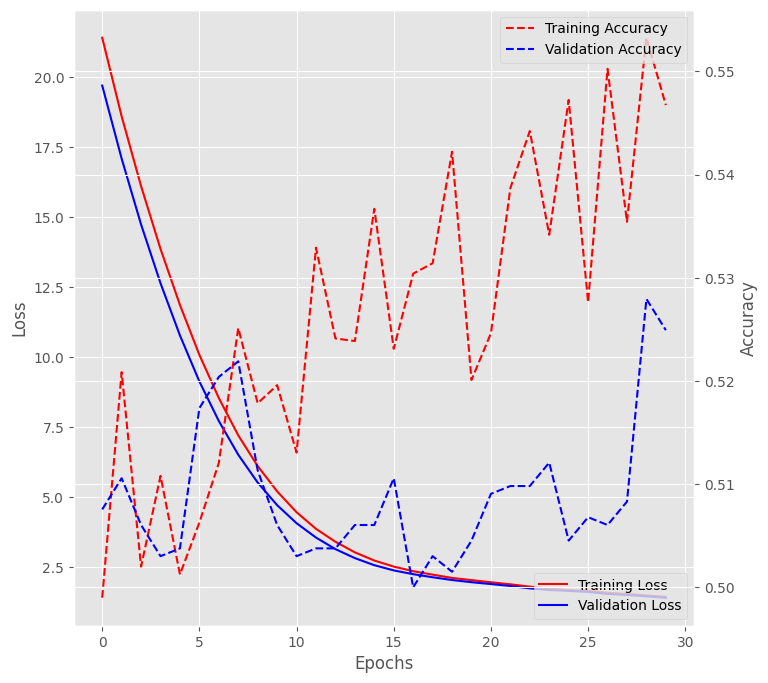

In [33]:
# plot loss and accuracy on train, validation data

plt.style.use('ggplot')

fig, ax=plt.subplots(figsize=(8,8))
ax.plot(average_loss_history,c='r', label="Training Loss")
ax.plot(average_val_loss_history,c='b', label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend(['Training Loss','Validation Loss'], loc="lower right")

ax2=ax.twinx()
ax2.plot(average_acc_history,c="r",linestyle="dashed", label="Training Accuracy")
ax2.plot(average_val_acc_history,c='b',linestyle="dashed", label="Validation Accuracy")
ax2.set_ylabel("Accuracy")
ax2.legend(["Training Accuracy", "Validation Accuracy"], loc="upper right")

plt.show()

16/16 [==============================] - 0s 832us/step


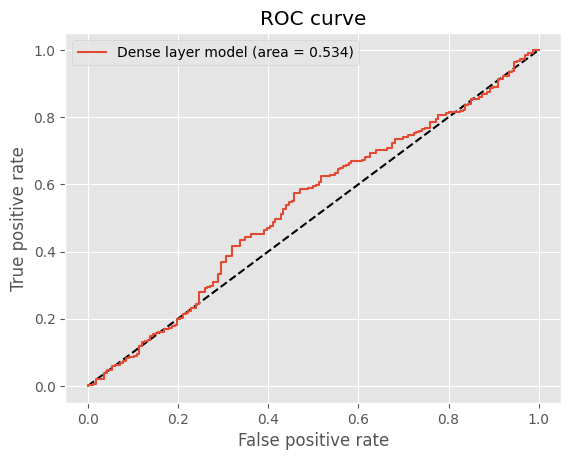

In [34]:
from sklearn.metrics import roc_curve
y_pred1 = model1.predict(X_test_dvs).ravel()
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred1)

from sklearn.metrics import auc
auc_1 = auc(fpr_1, tpr_1)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Dense layer model (area = {:.3f})'.format(auc_1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [35]:
# evaluate the model by using test data
loss_metrics = model1.evaluate(X_test_dvs,y_test,verbose=1)

16/16 [==============================] - 0s 933us/step - loss: 1.4663 - accuracy: 0.6048


## 1D Consolutional Neural Network
1D Convolutional Neural Network (1D CNN)은 시퀀스 데이터에 대해 합성곱 연산을 수행하는 뉴럴 네트워크입니다. 2D CNN이 이미지와 같은 2차원 데이터에 대해 작동하는 것과 유사하게, 1D CNN은 시간에 따른 연속적인 패턴이 있는 데이터(예: 시계열 데이터, 문장 등)에 대해 작동합니다.

1D CNN은 일반적으로 다음 세 가지 주요 구성 요소로 구성되어 있습니다:

Convolutional Layer: 합성곱 레이어는 입력 데이터에 대해 합성곱 연산을 수행하여 로컬 특징을 학습합니다. 합성곱 연산은 주어진 '커널' 또는 '필터'를 데이터의 부분적인 시퀀스에 대해 슬라이딩하면서 적용됩니다.

Activation Layer: 보통 ReLU(Rectified Linear Unit)와 같은 비선형 활성화 함수를 사용하여 학습된 특징 맵에 적용됩니다. 이는 모델이 더 복잡한 패턴을 학습하는 데 도움이 됩니다.

Pooling Layer: Pooling 레이어는 정보를 압축하고, 과적합을 방지하며, 계산 복잡성을 줄이기 위해 사용됩니다. Pooling 레이어는 일반적으로 Max Pooling이나 Average Pooling 연산을 사용합니다.

이 세 가지 레이어 타입은 일반적으로 여러 층을 쌓아서 1D CNN을 구성합니다.

1D CNN은 자연어 처리(NLP)에서 텍스트 분류나 감정 분석, 시계열 분석에서 패턴 인식, 음성 인식 등과 같은 다양한 분야에서 활용됩니다. 예를 들어, NLP에서는 각 단어(또는 n-gram)를 벡터로 표현한 후 이들을 시퀀스로 입력하여 문장의 로컬 특징을 학습하는 데 1D CNN을 사용할 수 있습니다.

In [36]:
# Before building CNN model, vectorize facts data
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, 
    output_mode="int",
    output_sequence_length = 500
)

text_vectorization.adapt(X_train)

X_train_processed = text_vectorization(X_train)
X_test_processed = text_vectorization(X_test)

In [37]:
# Build cnn model
def cnn_model():    
    input = keras.Input(shape=(500))
    x = layers.Embedding(input_dim=2000,output_dim=8,input_length=500, mask_zero=True)(input)
    x = layers.Conv1D(filters=40,kernel_size=10,activation="relu")(x)
    x = layers.MaxPool1D(pool_size=2,strides=2)(x)
    x = layers.GlobalAveragePooling1D()(x) 
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(10,activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=input,outputs=output)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
    return model

In [38]:
# train and cross validate the model
k = 4
num_validation_samples = len(X_train_dvs) // k
num_epochs = 30
batch_sizes = 50
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = X_train_processed[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = y_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        X_train_processed[:num_validation_samples * fold],
        X_train_processed[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        y_train[:num_validation_samples * fold],
        y_train[num_validation_samples * (fold + 1):]])
    
    model2 = cnn_model()

    history2 = model2.fit(training_data, training_targets, 
                    validation_data = (validation_data,validation_targets), 
                    epochs=num_epochs, batch_size=batch_sizes)

    val_loss_history2 = history2.history['val_loss']
    val_acc_history2 = history2.history['val_accuracy']
    loss_history2 = history2.history['loss']
    acc_history2 = history2.history['accuracy']
    all_val_loss_histories.append(val_loss_history2)
    all_loss_histories.append(loss_history2)
    all_val_acc_histories.append(val_acc_history2)
    all_acc_histories.append(acc_history2)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/30
20/20 [==============================] - 1s 16ms/step - loss: 0.6935 - accuracy: 0.4955 - val_loss: 0.6933 - val_accuracy: 0.4834
Epoch 2/30
20/20 [==============================] - 0s 10ms/step - loss: 0.6930 - accuracy: 0.5085 - val_loss: 0.6940 - val_accuracy: 0.4834
Epoch 3/30
20/20 [==============================] - 0s 11ms/step - loss: 0.6928 - accuracy: 0.4985 - val_loss: 0.6934 - val_accuracy: 0.4834
Epoch 4/30
20/20 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6934 - val_accuracy: 0.4834
Epoch 5/30
20/20 [==============================] - 0s 11ms/step - loss: 0.6918 - accuracy: 0.5256 - val_loss: 0.6925 - val_accuracy: 0.5106
Epoch 6/30
20/20 [==============================] - 0s 11ms/step - loss: 0.6892 - accuracy: 0.5307 - val_loss: 0.6924 - val_accuracy: 0.4834
Epoch 7/30
20/20 [==============================] - 0s 11ms/step - loss: 0.6831 - accuracy: 0.5176 - val_loss: 0.6897 - val_accuracy: 0.4804
Epoch 8/30
20

In [39]:
keras.utils.plot_model(model2,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [40]:
np.mean(average_val_acc_history)

0.5658610261976719

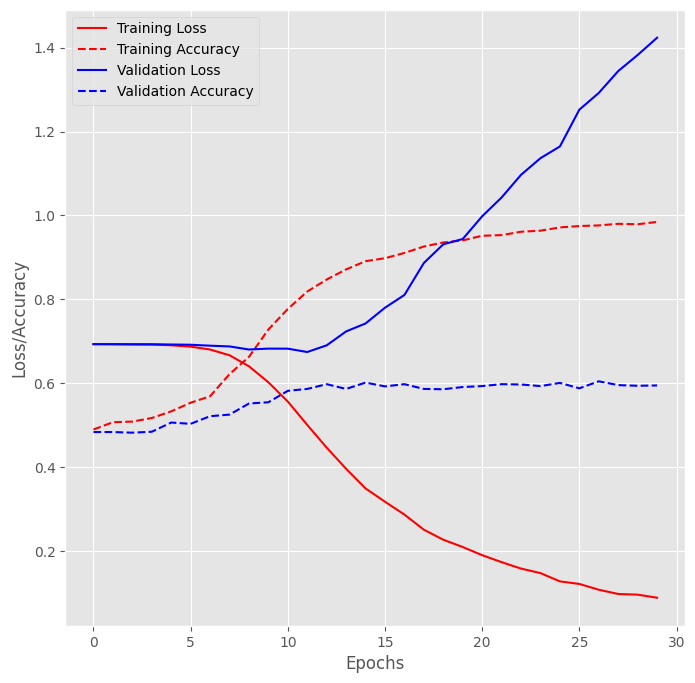

In [41]:
plt.style.use('ggplot')
plt.figure(figsize=(8,8))
plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

In [42]:
loss_metrics = model2.evaluate(X_test_processed,y_test,verbose=1)

 1/16 [>.............................] - ETA: 0s - loss: 2.1102 - accuracy: 0.5000

16/16 [==============================] - 0s 3ms/step - loss: 1.9163 - accuracy: 0.5060


16/16 [==============================] - 0s 2ms/step


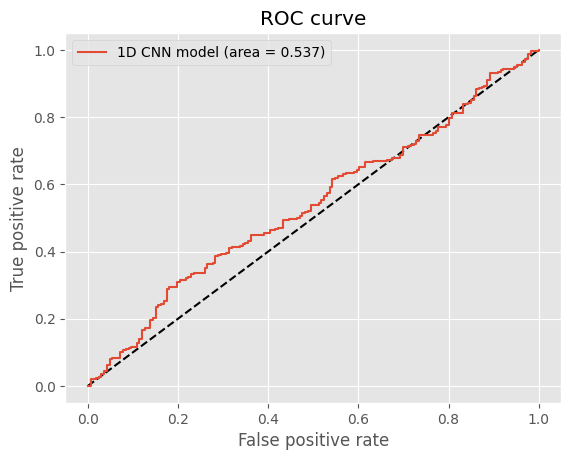

In [43]:
from sklearn.metrics import roc_curve
y_pred2 = model2.predict(X_test_processed).ravel()
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred2)

from sklearn.metrics import auc
auc_2 = auc(fpr_2, tpr_2)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_2, tpr_2, label='1D CNN model (area = {:.3f})'.format(auc_2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Dense layer with Text Vectorization layer

In [44]:
text_vectorization_bi_tfidf = keras.layers.TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode = "tf_idf",
    # standardize=custom_standardization_fn,
    # split=custom_split_fn
)

In [45]:
text_vectorization_bi_tfidf.adapt(X_train)  

In [46]:
binary_2gram_tfidf_text = text_vectorization_bi_tfidf(X_train)
binary_2gram_tfidf_text

<tf.Tensor: shape=(1326, 20000), dtype=float32, numpy=
array([[298.90347   ,  10.408533  ,   4.90003   , ...,   0.        ,
          0.        ,   0.        ],
       [517.7435    ,  14.571946  ,   4.90003   , ...,   0.        ,
          0.        ,   0.        ],
       [437.68008   ,  11.796337  ,   4.90003   , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [261.54053   ,   2.7756088 ,   0.70000434, ...,   0.        ,
          0.        ,   0.        ],
       [619.1572    ,  15.95975   ,   4.90003   , ...,   0.        ,
          0.        ,   0.        ],
       [213.50249   ,   6.939022  ,   2.8000174 , ...,   0.        ,
          0.        ,   0.        ]], dtype=float32)>

In [47]:
max_tokens=20000
hidden_dim=16

def td_idf_model():
    inputs = keras.Input(shape=(max_tokens,))
    x = keras.layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dense(200, activation="relu")(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dense(50, activation="tanh")(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])


    return model 

model_bi_tfidf = td_idf_model()
keras.utils.plot_model(model_bi_tfidf,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [48]:
k = 4
num_validation_samples = len(X_train) // k
num_epochs = 25
batch_sizes = 50
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = binary_2gram_tfidf_text[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = y_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        binary_2gram_tfidf_text[:num_validation_samples * fold],
        binary_2gram_tfidf_text[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        y_train[:num_validation_samples * fold],
        y_train[num_validation_samples * (fold + 1):]])
    
    model_bi_tfidf = td_idf_model()
    callbacks = [keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
      ]
    history = model_bi_tfidf.fit(training_data, training_targets, 
                    validation_data = (validation_data,validation_targets), 
                    epochs=num_epochs, batch_size=batch_sizes,callbacks=callbacks)
    #model = keras.models.load_model("tfidf_2gram.keras")

    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
20/20 [==============================] - 1s 13ms/step - loss: 0.7466 - accuracy: 0.5487 - val_loss: 0.6219 - val_accuracy: 0.6375
Epoch 2/25
20/20 [==============================] - 0s 7ms/step - loss: 0.5410 - accuracy: 0.7337 - val_loss: 0.5462 - val_accuracy: 0.7190
Epoch 3/25
20/20 [==============================] - 0s 7ms/step - loss: 0.2413 - accuracy: 0.9246 - val_loss: 0.6974 - val_accuracy: 0.7100
Epoch 4/25
20/20 [==============================] - 0s 6ms/step - loss: 0.0458 - accuracy: 0.9950 - val_loss: 1.2128 - val_accuracy: 0.5952
Epoch 5/25
20/20 [==============================] - 0s 6ms/step - loss: 0.0102 - accuracy: 0.9990 - val_loss: 1.1466 - val_accuracy: 0.7009
Epoch 6/25
20/20 [==============================] - 0s 6ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 1.2700 - val_accuracy: 0.6979
Epoch 7/25
20/20 [==============================] - 0s 6ms/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 1.4742 - val_accuracy: 0.7009
Epoch 8/25
20/20 [=

In [49]:
np.mean(average_val_acc_history)

0.6240181261301041

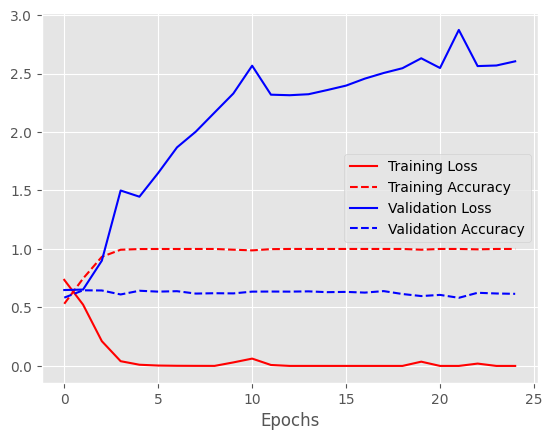

In [50]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

In [51]:
binary_2gram_tf_test = text_vectorization_bi_tfidf(X_test)
binary_2gram_tf_test

<tf.Tensor: shape=(496, 20000), dtype=float32, numpy=
array([[ 597.80695  ,   11.796337 ,    2.100013 , ...,    0.       ,
           0.       ,    0.       ],
       [ 571.11914  ,   11.796337 ,    5.6000347, ...,    0.       ,
           0.       ,    0.       ],
       [ 469.70547  ,    5.5512176,    3.5000217, ...,    0.       ,
           0.       ,    0.       ],
       ...,
       [1558.5681   ,   19.429262 ,   12.600079 , ...,    0.       ,
           0.       ,    0.       ],
       [ 651.18256  ,    7.632924 ,    2.100013 , ...,    0.       ,
           0.       ,    0.       ],
       [ 741.92114  ,   18.041456 ,    4.90003  , ...,    0.       ,
           0.       ,    0.       ]], dtype=float32)>

In [52]:
model_bi_tfidf.evaluate(binary_2gram_tf_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 4.5680 - accuracy: 0.4194


[4.567995071411133, 0.4193548262119293]

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 1ms/step


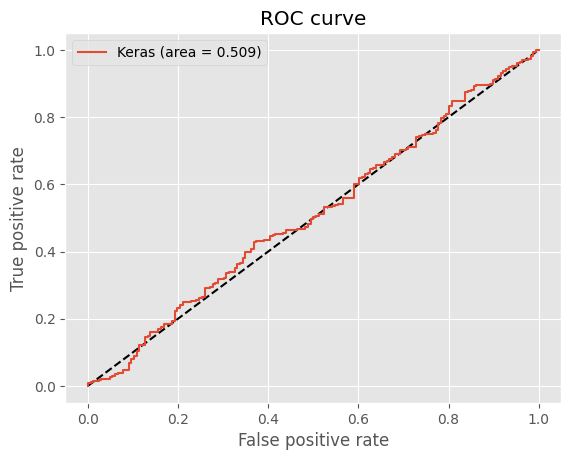

In [53]:
from sklearn.metrics import roc_curve
y_pred_keras = model_bi_tfidf.predict(binary_2gram_tf_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Recurrent Neural Network

In [54]:
# Bidirectional LSTM
text_vectorization = keras.layers.TextVectorization(
    max_tokens=1000, # maximum tokens are set to 1000 words
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
    ngrams =1 # set ngram = 1 (which means we will consider the seqenuce of the documents)
)

text_vectorization.adapt(train1['facts'])

In [55]:
def build_model():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    one_hot = tf.one_hot(processing, depth=1500) # we one-hot encode those, so it becomes a length x1500 vector.
    x = layers.Bidirectional(layers.LSTM(16))(one_hot) # operating in parallel and generate 32 LSTM (embeddings) in the end
    x = layers.Dropout(0.5)(x) # prevent the overfitting
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_lstm = build_model()

keras.utils.plot_model(model_lstm, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [56]:
with tf.device('/cpu:0'):
    k = 4
    num_validation_samples = len(X_train) // k
    num_epochs = 25
    batch_sizes = 250
    all_loss_histories = []
    all_val_loss_histories = []  
    all_acc_histories = []
    all_val_acc_histories = []

    # For each validation fold, we will train a full set of epochs, and store the history. 
    for fold in range(k):
        validation_data = X_train[num_validation_samples * fold:
                            num_validation_samples * (fold + 1)]
        validation_targets = y_train[num_validation_samples * fold:
                            num_validation_samples * (fold + 1)]
        training_data = np.concatenate([
            X_train[:num_validation_samples * fold],
            X_train[num_validation_samples * (fold + 1):]])
        training_targets = np.concatenate([
            y_train[:num_validation_samples * fold],
            y_train[num_validation_samples * (fold + 1):]])
        model_lstm = build_model()
        history = model_lstm.fit(training_data, training_targets, 
                            validation_data = (validation_data,validation_targets), 
                            epochs=num_epochs, batch_size=batch_sizes)
        val_loss_history = history.history['val_loss']
        val_acc_history = history.history['val_accuracy']
        loss_history = history.history['loss']
        acc_history = history.history['accuracy']
        all_val_loss_histories.append(val_loss_history)
        all_loss_histories.append(loss_history)
        all_val_acc_histories.append(val_acc_history)
        all_acc_histories.append(acc_history)

    average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
    average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
    average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
    average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
4/4 [==============================] - 21s 5s/step - loss: 0.6927 - accuracy: 0.5136 - val_loss: 0.6942 - val_accuracy: 0.4834
Epoch 2/25
4/4 [==============================] - 16s 4s/step - loss: 0.6934 - accuracy: 0.5126 - val_loss: 0.6939 - val_accuracy: 0.4955
Epoch 3/25
4/4 [==============================] - 16s 4s/step - loss: 0.6923 - accuracy: 0.5317 - val_loss: 0.6936 - val_accuracy: 0.5015
Epoch 4/25
4/4 [==============================] - 16s 4s/step - loss: 0.6920 - accuracy: 0.5266 - val_loss: 0.6935 - val_accuracy: 0.4864
Epoch 5/25
4/4 [==============================] - 15s 4s/step - loss: 0.6903 - accuracy: 0.5487 - val_loss: 0.6936 - val_accuracy: 0.4985
Epoch 6/25
4/4 [==============================] - 16s 5s/step - loss: 0.6907 - accuracy: 0.5437 - val_loss: 0.6934 - val_accuracy: 0.5106
Epoch 7/25
4/4 [==============================] - 18s 5s/step - loss: 0.6909 - accuracy: 0.5286 - val_loss: 0.6930 - val_accuracy: 0.5045
Epoch 8/25
4/4 [==================

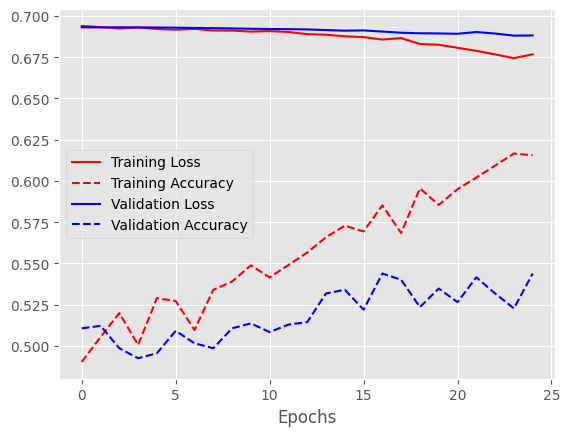

In [57]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

In [58]:
model_lstm.evaluate(X_test, y_test)

16/16 [==============================] - 6s 384ms/step - loss: 0.7031 - accuracy: 0.4315


[0.7031116485595703, 0.43145161867141724]

16/16 [==============================] - 7s 421ms/step


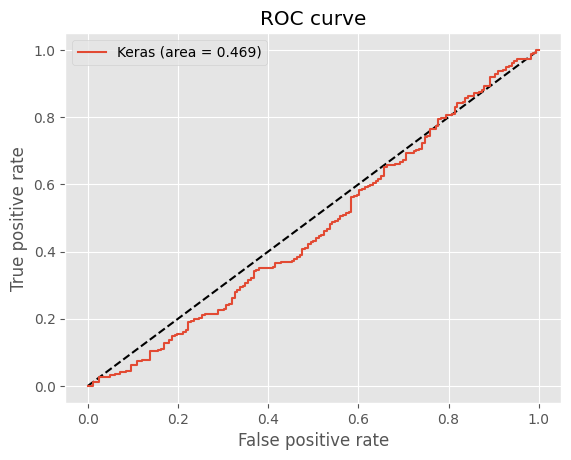

In [59]:
from sklearn.metrics import roc_curve
y_pred_keras = model_lstm.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Textual Embeddings

In [60]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=1000, # set the maximum tokens at 1000 words
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
    ngrams =1 # set ngram = 1 (which means we will consider the seqenuce of the documents)
)

text_vectorization.adapt(train1['facts'])

In [61]:
with tf.device('/cpu:0'):
    def build_model_text_embed():
        inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
        processing = text_vectorization(inputs)

        #we are setting 1000 as the vocabulary size, as we will be encoding numbers 0 to 999. 
        #We want the length of the word vector to be 8, hence output_dim is set to 8. 
        # The length of the input sequence to embedding layer will be 500.
        # Truncates after 500 tokens, and pads up to 500 tokens for shorter facts.
        # Mask zero means it will skip 0 tokens and will not pass them on.
        x = layers.Embedding(input_dim=1000,output_dim=8,input_length=500, mask_zero=True)(processing) # Embedding layer
        x = layers.Bidirectional(layers.LSTM(12))(x) #Bidirectional LSTM layer: # operating in parallel and generate 10 LSTM (embeddings) in the end 
        x = keras.layers.Dropout(0.5)(x)
        outputs = layers.Dense(1, activation="sigmoid")(x)
    
    
        model = keras.Model(inputs,outputs)
        model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
        return model

    model_lstm_text_embed = build_model_text_embed()

    keras.utils.plot_model(model_lstm_text_embed, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [62]:
with tf.device('/cpu:0'):
    k = 4
    num_validation_samples = len(X_train) // k
    num_epochs = 25
    batch_sizes = 250
    all_loss_histories = []
    all_val_loss_histories = []  
    all_acc_histories = []
    all_val_acc_histories = []

    # For each validation fold, we will train a full set of epochs, and store the history. 
    for fold in range(k):
        validation_data = X_train[num_validation_samples * fold:
                            num_validation_samples * (fold + 1)]
        validation_targets = y_train[num_validation_samples * fold:
                            num_validation_samples * (fold + 1)]
        training_data = np.concatenate([
            X_train[:num_validation_samples * fold],
            X_train[num_validation_samples * (fold + 1):]])
        training_targets = np.concatenate([
            y_train[:num_validation_samples * fold],
            y_train[num_validation_samples * (fold + 1):]])
        model_lstm_text_embed = build_model_text_embed()
        history = model_lstm_text_embed.fit(training_data, training_targets, 
                            validation_data = (validation_data,validation_targets), 
                            epochs=num_epochs, batch_size=batch_sizes)
        val_loss_history = history.history['val_loss']
        val_acc_history = history.history['val_accuracy']
        loss_history = history.history['loss']
        acc_history = history.history['accuracy']
        all_val_loss_histories.append(val_loss_history)
        all_loss_histories.append(loss_history)
        all_val_acc_histories.append(val_acc_history)
        all_acc_histories.append(acc_history)

    average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
    average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
    average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
    average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]   

Epoch 1/25
4/4 [==============================] - 7s 891ms/step - loss: 0.6931 - accuracy: 0.5246 - val_loss: 0.6934 - val_accuracy: 0.4804
Epoch 2/25
4/4 [==============================] - 1s 196ms/step - loss: 0.6926 - accuracy: 0.5246 - val_loss: 0.6933 - val_accuracy: 0.4834
Epoch 3/25
4/4 [==============================] - 1s 186ms/step - loss: 0.6930 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4713
Epoch 4/25
4/4 [==============================] - 1s 196ms/step - loss: 0.6921 - accuracy: 0.5216 - val_loss: 0.6931 - val_accuracy: 0.4773
Epoch 5/25
4/4 [==============================] - 1s 175ms/step - loss: 0.6917 - accuracy: 0.5467 - val_loss: 0.6930 - val_accuracy: 0.4864
Epoch 6/25
4/4 [==============================] - 1s 175ms/step - loss: 0.6917 - accuracy: 0.5618 - val_loss: 0.6930 - val_accuracy: 0.4894
Epoch 7/25
4/4 [==============================] - 1s 205ms/step - loss: 0.6914 - accuracy: 0.5377 - val_loss: 0.6930 - val_accuracy: 0.4683
Epoch 8/25
4/4 [====

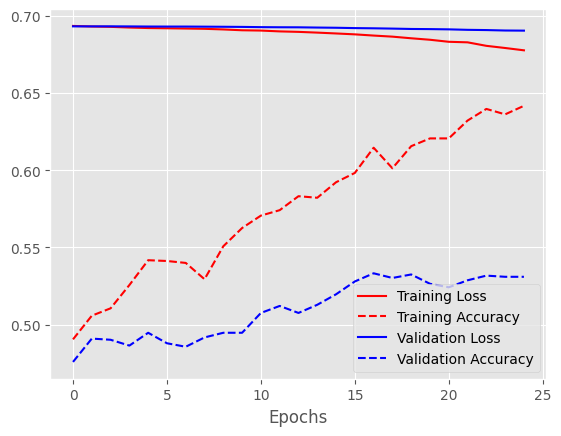

In [63]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

In [64]:
model_lstm_text_embed.evaluate(X_test, y_test)

16/16 [==============================] - 0s 23ms/step - loss: 0.6950 - accuracy: 0.4960


[0.6950488090515137, 0.4959677457809448]

16/16 [==============================] - 2s 19ms/step


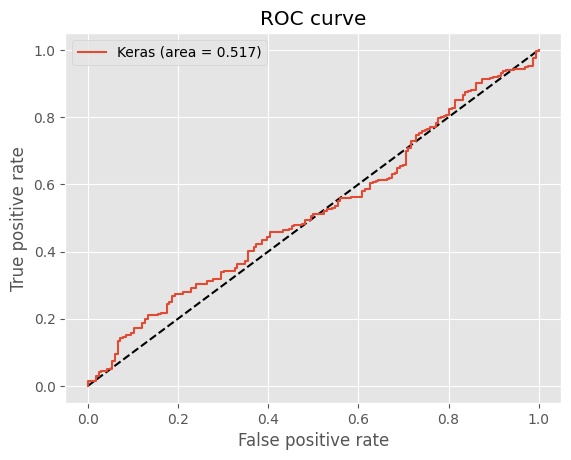

In [65]:
from sklearn.metrics import roc_curve
y_pred_keras = model_lstm_text_embed.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Applying to Test Data

In [71]:
dfTest = pd.DataFrame(test['facts'])
test.head()

,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal courts to detain an arrestee prior to trial if the government could prove that the individual was potentially dangerous to other people in the community. Prosecutors alleged that Salerno and another person in this case were prominent figures in the La Cosa Nostra crime family.\n
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.","Lexecon Inc. was a defendant in a class action lawsuit. Under 28 USC section 1407(a), the lawsuit was transferred for pretrial proceedings to the District of Arizona. Section 1407(a) authorizes the Judicial Panel on Multidistrict Litigation to transfer civil actions with common issues of fact ""to any district for coordinated or consolidated pretrial proceedings,"" but provides that the Panel ""shall"" remand any such action to the original district ""at or before the conclusion of such pretrial proceedings."" After claims against it were dismissed, Lexecon brought suit against Milberg Weiss Bershad Hynes & Lerach and others (Milberg) in the class action lawsuit in the Northern District of Illinois. Ultimately, the Panel, under section 1407(a), ordered the case transferred to the District of Arizona. Afterwards, Lexecon moved for the Arizona District Court to remand the case to Illinois. Milberg filed a countermotion requesting the Arizona District Court to invoke section 1404(a) to ""transfer"" the case to itself for trial.Ultimately, the court assigned the case to itself and the Court of Appeals affirmed its judgment.\n"
2,TEST_0002,"No. 07-582\t Title: \t Federal Communications Commission, et al.","Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broadcast the Billboard Music Awards, an annual program honoring top-selling musicians. During the broadcasts, one musician used an explicative in his acceptance speech, and a presenter used two expletives. The Federal Communications Commission (FCC), although it had previously taken the position that such fleeting and isolated expletives did not violate its indecency regime, issued notices of liability to Fox for broadcasting the profane language. The FCC argued that previous decisions referring to ""fleeting"" expletives were merely staff letters and dicta and did not accurately represent its position on the matter. Fox appealed the FCC sanctions to the U.S. Court of Appeals for the Second Circuit.\nThe Second Circuit held that the FCC's liability order was ""arbitrary and capricious"" under the governing Administrative Procedure Act because the FCC had completely reversed its position on fleeting expletives without giving a proper justification. The Second Circuit also failed to find any evidence that the expletives were harmful.\n"
3,TEST_0003,Harold Kaufman,United States,"During his trial for armed robbery of a federally insured savings and loan association, Harold Kaufman admitted to the crime but unsuccessfully claimed insanity. He was convicted and the U.S. Court of Appeals for the Eighth Circuit affirmed. Kaufman then filed a post-conviction motion in district court challenging the evidence that proved his sanity. He alleged that the evidence was unlawfully seized in violation of the Fourth Amendment. The district court denied relief, holding that unlawful search and seizure was not an available attack in post-conviction proceedings. The Eighth Circuit affirmed.\n"
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant authorizing the search of Paul and Erma Berger's Montana ranch for evidence of the taking of wildlife in violation of federal law. Later, a multiple-vehicle caravan consisting of government agents and a crew of photographers and reporters from CNN proceeded to the ranch. In executing the warrant, the federal officers allowed the media crew to accompany and observe them. Subsequently, the Berger's filed suit, asserting that the officials, special agents of 

## Inference & Submission

In [66]:
# submit = pd.read_csv('C:/data/project/sample_submission.csv')
# submit['first_party_winner'] = predcsv
# submit.to_csv('./sample_submission.csv', index=False)
# print('Done')